In [1]:
import skbio
import sklearn
import tslearn
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

### Number of origin region occurrences altogether

In [14]:
# Read data
data = pd.read_csv('/Users/maijahavusela/Desktop/gradu/data/10.4. saadut/Erasmus_2014-2022_aggregated_NUTS3_v2021.csv',sep=',')

# Splitting the origin and destination NUTS 3 codes to separate columns
data['orig'] = data['OD_ID'].apply(lambda x: x.split('_')[0])
data['dest'] = data['OD_ID'].apply(lambda x: x.split('_')[1])

# Getting a list of all origins per destination and renaming the column
opd = data.groupby(['dest', 'year']).agg({'orig':lambda x: list(x)}).reset_index().rename(columns={'dest':'NUTS3'})

# Flattening the 'orig' column and counting occurrences of each NUTS 3 region as an origin
flat_list = [item for sublist in opd['orig'] for item in sublist]
counter = Counter(flat_list) # All years


### Number of origin region occurrences per destination NUTS 3

In [15]:
# Dictionary to store the Counter results for each destination NUTS 3 region
origin_count_per_dest_nuts3 = {}

# Iterating over each unique destination NUTS 3 region
for nuts3 in opd['NUTS3'].unique():
    # Getting all regions in the 'orig' column for this NUTS 3 region
    regions = [region for sublist in opd[opd['NUTS3'] == nuts3]['orig'] for region in sublist]
    # Counting occurrences of each origin NUTS 3 region using Counter
    origin_count_per_dest_nuts3[nuts3] = Counter(regions)
    
# All years

### The Shannon-Weiner diversity index (not normalized)
Shannon equitability index?? Se on normalisoitu 0 ja 1 välille

In [17]:
# Defining a function to calculate the Shannon-Weiner index using skbio
def calculate_shannon_weiner_with_skbio(region_counter):
    counts = list(region_counter.values())  # Converting counter to a list of counts
    shannon_index = skbio.diversity.alpha.shannon(counts)
    return shannon_index

# Calculating Shannon-Weiner index for each destination NUTS 3 region
diversity_indexes = {}
for nuts3, counter in origin_count_per_dest_nuts3.items():
    shannon_index = calculate_shannon_weiner_with_skbio(counter)
    diversity_indexes[nuts3] = shannon_index

# Output the results
for nuts3, index in diversity_indexes.items():
    #print(f"Shannon-Weiner index for {nuts3}: {index:.4f}")
    

SyntaxError: incomplete input (3478765584.py, line 16)

### Clustering

/var/folders/y_/10361q_17p1glmj2v2x0zsth0000gn/T/ipykernel_52451/1977722820.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Oranges', len(unique_clusters))


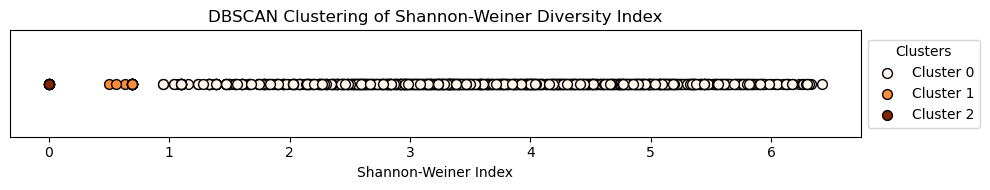

In [5]:
# Converting the dictionary to dataframe
df = pd.DataFrame(list(diversity_indexes.items()), columns=['nuts3', 'shannon_index'])

# DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=2)
df['cluster'] = dbscan.fit_predict(df[['shannon_index']])

# Unique cluster labels (including -1 for noise)
unique_clusters = sorted(df['cluster'].unique())

# Choosing a colour map for the clusters
colors = plt.cm.get_cmap('Oranges', len(unique_clusters))

# Plotting each cluster
plt.figure(figsize=(10, 2))
for i, cluster in enumerate(unique_clusters):
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(
        cluster_data['shannon_index'],
        [0]*len(cluster_data),
        label=f'Cluster {cluster}' if cluster != -1 else 'Noise',
        color=colors(i),
        edgecolor='black',
        s=50
    )

plt.yticks([])  # 1D, no need for y
plt.xlabel('Shannon-Weiner Index')
plt.title('DBSCAN Clustering of Shannon-Weiner Diversity Index')
plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5), # Outside of graph
    title='Clusters'
)
plt.tight_layout()
plt.show()